
# Rocket League Match Predictor 

This notebook trains a **no‑leak match‑winner predictor** using your two CSVs:

- `matches_by_teams.csv` — per-team stats per match (includes `winner`)
- `main.csv` — match/game metadata with a date column

**Design choices:**
- Uses **only past data** via `shift(1)` + rolling means
- Builds **match‑level features** by subtracting Team B from Team A
- **Time‑ordered** 80/20 split for evaluation
- Trains **Logistic Regression** (with scaling) and **Random Forest**
- Saves artifacts for reuse (`rl_match_predictor.pkl`, `test_set_predictions.csv`)
- Includes an **inference helper** (predict probability for two teams as of a date)


In [3]:

# 1) Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, ConfusionMatrixDisplay, RocCurveDisplay

import pickle
import warnings
warnings.filterwarnings("ignore")


## Load Data

In [4]:

# 2) Load Data (adjust paths if needed)
matches_path = 'matches_by_teams.csv'
main_path    = 'main.csv'

matches = pd.read_csv(matches_path)
main    = pd.read_csv(main_path)

print("matches shape:", matches.shape)
print("main shape:", main.shape)


matches shape: (10594, 54)
main shape: (18740, 36)


## Dates & Per-Match Metadata

In [5]:

# 3) Dates & Per-Match Metadata
date_col = 'game_date' if 'game_date' in main.columns else ('match_date' if 'match_date' in main.columns else None)
if date_col is None:
    raise ValueError("No date column found in main.csv. Expected 'game_date' or 'match_date'.")

main[date_col] = pd.to_datetime(main[date_col], errors='coerce', utc=True)

meta_candidates = ['match_id', date_col, 'event', 'event_region', 'event_tier',
                   'match_format', 'stage', 'stage_is_lan', 'stage_is_qualifier']
meta_cols = [c for c in meta_candidates if c in main.columns]

main_match = (main.sort_values([date_col, 'match_id'])
                  .drop_duplicates(subset=['match_id'], keep='first')[meta_cols])

main_match.head(3)


,match_id,game_date,event,event_region,event_tier,match_format,stage,stage_is_lan,stage_is_qualifier
6,6159ad3d143c37878b2384ab,2021-10-08 06:06:28+00:00,Regional 1,Oceania,Qualifier,best-of-5,Swiss Stage,False,True
0,6159ad3d143c37878b2384a9,2021-10-08 06:08:23+00:00,Regional 1,Oceania,Qualifier,best-of-5,Swiss Stage,False,True
14,6159ad3d143c37878b2384ae,2021-10-08 06:08:41+00:00,Regional 1,Oceania,Qualifier,best-of-5,Swiss Stage,False,True


## Per-Team Rows & Feature Selection

In [6]:

# 4) Per-Team Rows & Feature Selection
team_cols_pref = ['match_id','team_id','team_slug','team_name','team_region','color','winner']
team_cols = [c for c in team_cols_pref if c in matches.columns]
if 'match_id' not in team_cols or 'team_id' not in team_cols:
    raise ValueError("Expected 'match_id' and 'team_id' in matches_by_teams.csv.")

# Auto-select numeric features (exclude ids/target)
exclude_exact = {'match_id','team_id','winner'}
numeric_cols = [c for c in matches.columns
                if c not in exclude_exact and np.issubdtype(matches[c].dtype, np.number)]

# Prefer typical RL stat families; fall back to all numeric if none match
preferred_prefixes = ['core_', 'boost_', 'movement_', 'positioning_', 'demo_']
rl_like = [c for c in numeric_cols if any(c.startswith(p) for p in preferred_prefixes)]
feature_candidates = rl_like if rl_like else numeric_cols
if len(feature_candidates) == 0:
    raise ValueError("No usable numeric feature columns found in matches_by_teams.csv.")

print(f"Using {len(feature_candidates)} numeric features (first 12): {sorted(feature_candidates)[:12]}")

# Build per_team INCLUDING feature columns
per_team = matches[team_cols + feature_candidates].copy()

# Normalize winner to 0/1
if 'winner' in per_team.columns:
    per_team['winner'] = per_team['winner'].astype(int) if per_team['winner'].dtype != bool else per_team['winner'].astype(int)
else:
    raise ValueError("Target column 'winner' missing in matches_by_teams.csv.")

# Attach date/meta and sort
per_team = (per_team.merge(main_match, on='match_id', how='left')
                    .sort_values(['team_id', date_col])
                    .reset_index(drop=True))

per_team.head(3)


Using 46 numeric features (first 12): ['boost_amount_collected', 'boost_amount_collected_big', 'boost_amount_collected_small', 'boost_amount_overfill', 'boost_amount_overfill_stolen', 'boost_amount_stolen', 'boost_amount_stolen_big', 'boost_amount_stolen_small', 'boost_amount_used_while_supersonic', 'boost_avg_amount', 'boost_bcpm', 'boost_bpm']


,match_id,team_id,team_slug,team_name,team_region,color,winner,core_shots,core_goals,core_saves,...,demo_inflicted,demo_taken,game_date,event,event_region,event_tier,match_format,stage,stage_is_lan,stage_is_qualifier
0,6159acd3143c37878b23848f,6020bc70f1e4807cc7002386,https://octane.gg/teams/2386-rogue,ROGUE,North America,blue,0,32.0,8.0,20.0,...,17.0,9.0,2021-10-10 23:15:58+00:00,Regional 1,North America,Qualifier,best-of-5,Swiss Stage,False,True
1,6159acd3143c37878b23849b,6020bc70f1e4807cc7002386,https://octane.gg/teams/2386-rogue,ROGUE,North America,orange,1,29.0,11.0,11.0,...,12.0,14.0,2021-10-11 00:50:42+00:00,Regional 1,North America,Qualifier,best-of-5,Swiss Stage,False,True
2,61606146f8090ec745286f91,6020bc70f1e4807cc7002386,https://octane.gg/teams/2386-rogue,ROGUE,North America,blue,0,43.0,6.0,22.0,...,12.0,19.0,2021-10-15 13:16:43+00:00,Regional 1,North America,A,best-of-5,Swiss Stage,False,False


## Rolling (Past-Only) Features

In [7]:

# 5) Rolling (Past-Only) Features
ROLL_N = 5

def _roll_mean(s):
    # last N matches BEFORE current match
    return s.shift(1).rolling(ROLL_N, min_periods=1).mean()

roll_frames = []
for col in feature_candidates:
    r = (per_team.groupby('team_id')[col]
         .apply(_roll_mean)
         .rename(f'{col}_roll{ROLL_N}_mean'))
    roll_frames.append(r)

rolled = pd.concat(roll_frames, axis=1).reset_index(level=0, drop=True)
per_team_rolled = pd.concat([per_team, rolled], axis=1)

roll_cols = [c for c in per_team_rolled.columns if c.endswith(f'_roll{ROLL_N}_mean')]
per_team_rolled[roll_cols] = per_team_rolled[roll_cols].fillna(per_team_rolled[roll_cols].mean())

print(f"Built {len(roll_cols)} rolling features over last {ROLL_N} matches.")
per_team_rolled[roll_cols].head(3)


Built 46 rolling features over last 5 matches.


,core_shots_roll5_mean,core_goals_roll5_mean,core_saves_roll5_mean,core_assists_roll5_mean,core_score_roll5_mean,core_shooting_percentage_roll5_mean,boost_bpm_roll5_mean,boost_bcpm_roll5_mean,boost_avg_amount_roll5_mean,boost_amount_collected_roll5_mean,...,movement_count_powerslide_roll5_mean,positioning_time_defensive_third_roll5_mean,positioning_time_neutral_third_roll5_mean,positioning_time_offensive_third_roll5_mean,positioning_time_defensive_half_roll5_mean,positioning_time_offensive_half_roll5_mean,positioning_time_behind_ball_roll5_mean,positioning_time_in_front_ball_roll5_mean,demo_inflicted_roll5_mean,demo_taken_roll5_mean
0,32.397461,8.533812,18.340691,6.589626,4420.951621,26.436671,4907.423182,5043.871565,589.450356,29531.167368,...,915.274061,2093.525559,1410.345341,886.354133,2847.206561,1543.01126,3164.985997,1225.238859,12.330484,12.342838
1,32.000000,8.000000,20.000000,8.000000,4533.000000,25.000000,5148.000000,5292.557870,555.920000,29872.000000,...,690.000000,2073.900000,1347.470000,810.820000,2797.270000,1434.86000,3068.990000,1163.190000,17.000000,9.000000
2,30.500000,9.500000,15.500000,9.500000,4241.000000,31.465517,4444.500000,4574.947870,486.495000,25886.500000,...,615.000000,1797.625000,1191.190000,718.000000,2434.350000,1272.44500,2744.740000,962.085000,14.500000,11.500000


## Build Match-Level Examples (Team A − Team B)

In [8]:

# 6) Build Match-Level Examples (Team A − Team B)
def build_pairs(df, date_col, roll_cols):
    rows = []
    for mid, grp in df.groupby('match_id', sort=False):
        if len(grp) != 2:
            continue
        sort_key = 'team_name' if 'team_name' in grp.columns else 'team_id'
        grp = grp.sort_values(sort_key)
        a, b = grp.iloc[0], grp.iloc[1]
        diff = a[roll_cols].values - b[roll_cols].values
        y = int(a['winner'])  # whether Team A (alphabetical) won
        rows.append((diff, y, {
            'match_id': mid,
            'date': a[date_col],
            'teamA_id': a['team_id'],
            'teamA_name': a.get('team_name', str(a['team_id'])),
            'teamB_id': b['team_id'],
            'teamB_name': b.get('team_name', str(b['team_id']))
        }))

    if not rows:
        return pd.DataFrame(), np.array([]), pd.DataFrame()

    X = np.vstack([r[0] for r in rows])
    y = np.array([r[1] for r in rows])
    meta_df = pd.DataFrame([r[2] for r in rows])
    X_df = pd.DataFrame(X, columns=[f'diff__{c}' for c in roll_cols])
    return X_df, y, meta_df

X_df, y_vec, meta_df = build_pairs(per_team_rolled, date_col, roll_cols)
if X_df.empty:
    raise RuntimeError("No valid matches with exactly two teams found after processing.")

mask = meta_df['date'].notna().values

X_df   = X_df.loc[mask].reset_index(drop=True)
meta_df = meta_df.loc[mask].reset_index(drop=True)
y_vec  = y_vec[mask]

# now lengths align
assert len(X_df) == len(meta_df) == len(y_vec)

data = pd.concat([meta_df, X_df], axis=1).sort_values('date').reset_index(drop=True)
data['label'] = y_vec.astype(int)

feature_cols = [c for c in data.columns if c.startswith('diff__')]
print(f"Final training rows: {len(data)} | Features per row: {len(feature_cols)}")


Final training rows: 4331 | Features per row: 46


## Train/Test Split, Train Models, Evaluate

In [9]:

# 7) Train/Test Split, Train Models, Evaluate
split_idx = int(len(data) * 0.80)
train_df = data.iloc[:split_idx].copy()
test_df  = data.iloc[split_idx:].copy()

X_train, y_train = train_df[feature_cols].values, train_df['label'].values
X_test,  y_test  = test_df[feature_cols].values,  test_df['label'].values

logreg = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
rf = RandomForestClassifier(n_estimators=400, min_samples_split=4, min_samples_leaf=2, random_state=42, n_jobs=-1)

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def evaluate(name, model):
    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    proba_tr = model.predict_proba(X_train)[:,1]
    proba_te = model.predict_proba(X_test)[:,1]
    return {
        'model': name,
        'train_acc': accuracy_score(y_train, yhat_tr),
        'test_acc':  accuracy_score(y_test,  yhat_te),
        'train_auc': roc_auc_score(y_train, proba_tr),
        'test_auc':  roc_auc_score(y_test,  proba_te),
        'train_logloss': log_loss(y_train, proba_tr),
        'test_logloss':  log_loss(y_test,  proba_te)
    }, (yhat_te, proba_te)

r1, (yhat_log_te, proba_log_te) = evaluate('LogisticRegression', logreg)
r2, (yhat_rf_te,  proba_rf_te)  = evaluate('RandomForest', rf)

perf = pd.DataFrame([r1, r2]).round(4)
perf


,model,train_acc,test_acc,train_auc,test_auc,train_logloss,test_logloss
0,LogisticRegression,0.5375,0.5490,0.5582,0.5201,0.6878,0.6969
1,RandomForest,0.9893,0.4567,0.9997,0.4576,0.2715,0.7187


## Plots

<Figure size 640x480 with 0 Axes>

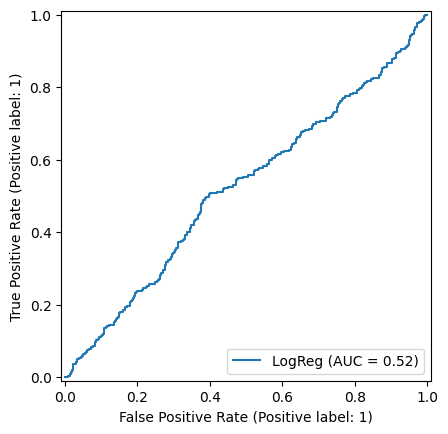

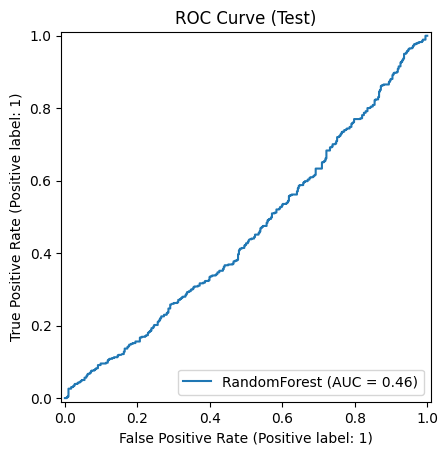

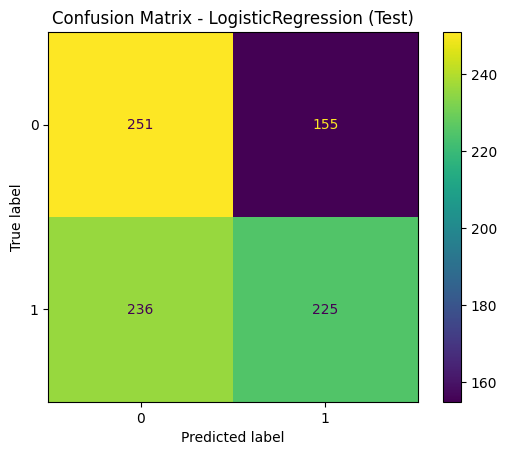

In [10]:

# 8) Plots
plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_log_te, name='LogReg')
RocCurveDisplay.from_predictions(y_test, proba_rf_te,  name='RandomForest')
plt.title('ROC Curve (Test)')
plt.show()

best_name = 'LogisticRegression' if r1['test_auc'] >= r2['test_auc'] else 'RandomForest'
best_pred = yhat_log_te if best_name == 'LogisticRegression' else yhat_rf_te
ConfusionMatrixDisplay.from_predictions(y_test, best_pred)
plt.title(f'Confusion Matrix - {best_name} (Test)')
plt.show()


## Save Artifacts

In [11]:

# 9) Save Artifacts
best_model = logreg if r1['test_auc'] >= r2['test_auc'] else rf
artifact = {
    'model_name': 'LogisticRegression' if r1['test_auc'] >= r2['test_auc'] else 'RandomForest',
    'model': best_model,
    'feature_cols': feature_cols,
    'roll_cols': roll_cols,
    'roll_window': 5,
    'built_on': datetime.utcnow().isoformat() + 'Z'
}
with open('rl_match_predictor.pkl', 'wb') as f:
    pickle.dump(artifact, f)

out_preds = test_df[['match_id','date','teamA_name','teamB_name','label']].copy()
out_preds['prob_A_wins'] = best_model.predict_proba(test_df[feature_cols].values)[:,1]
out_preds.rename(columns={'label':'actual_A_won'}, inplace=True)
out_preds.to_csv('test_set_predictions.csv', index=False)

print("Saved -> rl_match_predictor.pkl")
print("Saved -> test_set_predictions.csv")


Saved -> rl_match_predictor.pkl
Saved -> test_set_predictions.csv


## Inference Helper

In [12]:

# 10) Inference Helper
import difflib

def _date_col_from(df: pd.DataFrame) -> str:
    for c in ('date', 'game_date', 'match_date'):
        if c in df.columns:
            return c
    raise ValueError("No date-like column found in per_team_rolled.")

def _find_team_name(name: str, pool: pd.Series) -> str | None:
    """Return the best matching team name from pool (case-insensitive, fuzzy)."""
    names = [n for n in pool.dropna().unique() if isinstance(n, str)]
    # Exact, case-insensitive
    for n in names:
        if n.casefold() == name.casefold():
            return n
    # Fuzzy fallback
    matches = difflib.get_close_matches(name, names, n=1, cutoff=0.6)
    return matches[0] if matches else None

def _latest_roll_for_team(team_name: str, as_of: str | None = None):
    if 'team_name' not in per_team_rolled.columns:
        raise ValueError("per_team_rolled missing 'team_name' column.")
    dcol = _date_col_from(per_team_rolled)
    # Resolve actual team name (tolerant to case/typos)
    actual = _find_team_name(team_name, per_team_rolled['team_name'])
    if actual is None:
        return None  # team not found
    df = per_team_rolled[per_team_rolled['team_name'] == actual].copy()
    if as_of is not None:
        as_of_ts = pd.to_datetime(as_of, utc=True)
        df = df[df[dcol] < as_of_ts]
    if df.empty:
        return None  # no history before as_of (or at all)
    df = df.sort_values(dcol)
    return df.iloc[-1][roll_cols].values

def predict_match_prob(teamA_name: str, teamB_name: str, as_of: str | None = None) -> float:
    vecA = _latest_roll_for_team(teamA_name, as_of=as_of)
    vecB = _latest_roll_for_team(teamB_name, as_of=as_of)
    if vecA is None or vecB is None:
        # Help the user debug which one failed
        missing = []
        if vecA is None: missing.append(f"'{teamA_name}'")
        if vecB is None: missing.append(f"'{teamB_name}'")
        raise ValueError(f"Missing history for: {', '.join(missing)}. "
                         f"Check spelling/case or choose a later 'as_of' date.")
    diff = (vecA - vecB).reshape(1, -1)
    # Align to training schema
    tmp = pd.DataFrame(diff, columns=roll_cols)
    X = tmp.rename(columns={c: f'diff__{c}' for c in roll_cols})[artifact['feature_cols']].values
    return float(artifact['model'].predict_proba(X)[:,1])

def predict_match(teamA_name: str, teamB_name: str, as_of: str | None = None, return_prob=False):

    vecA = _latest_roll_for_team(teamA_name, as_of=as_of)
    vecB = _latest_roll_for_team(teamB_name, as_of=as_of)

    if vecA is None or vecB is None:
        missing = []
        if vecA is None: missing.append(f"'{teamA_name}'")
        if vecB is None: missing.append(f"'{teamB_name}'")
        raise ValueError(f"Missing history for: {', '.join(missing)}. "
                         f"Check spelling/case or choose a later 'as_of' date.")

    # Build match feature vector
    diff = (vecA - vecB).reshape(1, -1)
    tmp = pd.DataFrame(diff, columns=roll_cols)
    X = tmp.rename(columns={c: f'diff__{c}' for c in roll_cols})[artifact['feature_cols']].values

    prob_A = artifact['model'].predict_proba(X)[:,1][0]

    # format message
    if prob_A >= 0.5:
        winner = teamA_name
        prob = prob_A
    else:
        winner = teamB_name
        prob = 1 - prob_A

    message = f"{winner} is predicted to win with {prob*100:.1f}% confidence."
    print(message)

    if return_prob:
        return winner, prob

In [13]:
# Example usage:
predict_match("G2 Esports", "NRG")

G2 Esports is predicted to win with 60.6% confidence.


In [14]:
# Example usage with date:
predict_match("G2 Esports", "NRG", as_of="2022-06-01")

G2 Esports is predicted to win with 64.0% confidence.
